# Cliff Walking RL

### Required imports

In [1]:
import gymnasium as gym
import numpy as np
from collections import defaultdict

### Agent class

In [2]:
class CliffWalkingAgent:
    
    def __init__(
            self,
            env: gym.Env,
            learning_rate : float,
            initial_epsilon: float,
            epsilon_decay: float,
            final_epsilon: float,
            discount_factor: float = 0.9
            ):
        
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []
    
    def get_action(self, obs: tuple[int, int, bool]) -> int:

        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
        
    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


### Learning

In [3]:
from gymnasium.wrappers import RecordVideo, RecordEpisodeStatistics
from tqdm import tqdm
from matplotlib import pyplot as plt

In [8]:
def learn(
        learning_rate: float,
        n_episodes: int,
        start_epsilon: float,
        epsilon_decay: float, 
        final_epsilon: float,
        name: str,
        record_period: int = 250,
        ):
    
    env = gym.make("CliffWalking-v0", render_mode='rgb_array')
    env = RecordVideo(env, video_folder=f"CliffWalking_{name}", name_prefix="training",
                  episode_trigger=lambda x: x % record_period == 0)
    env = RecordEpisodeStatistics(env, buffer_length=n_episodes)
    
    agent = CliffWalkingAgent(
        env=env,
        learning_rate=learning_rate,
        initial_epsilon=start_epsilon,
        epsilon_decay=epsilon_decay,
        final_epsilon=final_epsilon,
    )
    
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False
    
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
    
            agent.update(obs, action, reward, terminated, next_obs)
    
            done = terminated or truncated
            obs = next_obs

        agent.decay_epsilon()
        
    def get_moving_avgs(arr, window, convolution_mode):
        return np.convolve(
            np.array(arr).flatten(),
            np.ones(window),
            mode=convolution_mode
        ) / window

    rolling_length = 500
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
    
    axs[0].set_title("Episode rewards")
    reward_moving_average = get_moving_avgs(
        env.return_queue,
        rolling_length,
        "valid"
    )
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
    
    axs[1].set_title("Episode lengths")
    length_moving_average = get_moving_avgs(
        env.length_queue,
        rolling_length,
        "valid"
    )
    axs[1].plot(range(len(length_moving_average)), length_moving_average)
    
    axs[2].set_title("Training Error")
    training_error_moving_average = get_moving_avgs(
        agent.training_error,
        rolling_length,
        "same"
    )
    axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
    plt.tight_layout()
    plt.savefig(f"Charts_for_cliff_walking_{name}.png")
    plt.show()
    

### Test 1

In [6]:
learning_rate = 0.001
n_episodes = 5_000
start_epsilon = 0.7
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.2
name = "test01"

/Users/krzysztofczerenko/Projects_6_semester/python_env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/krzysztofczerenko/Projects_6_semester/Inteligencja obliczeniowa/Project03/CliffWalking_test01 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
100%|██████████| 5000/5000 [00:13<00:00, 380.74it/s] 


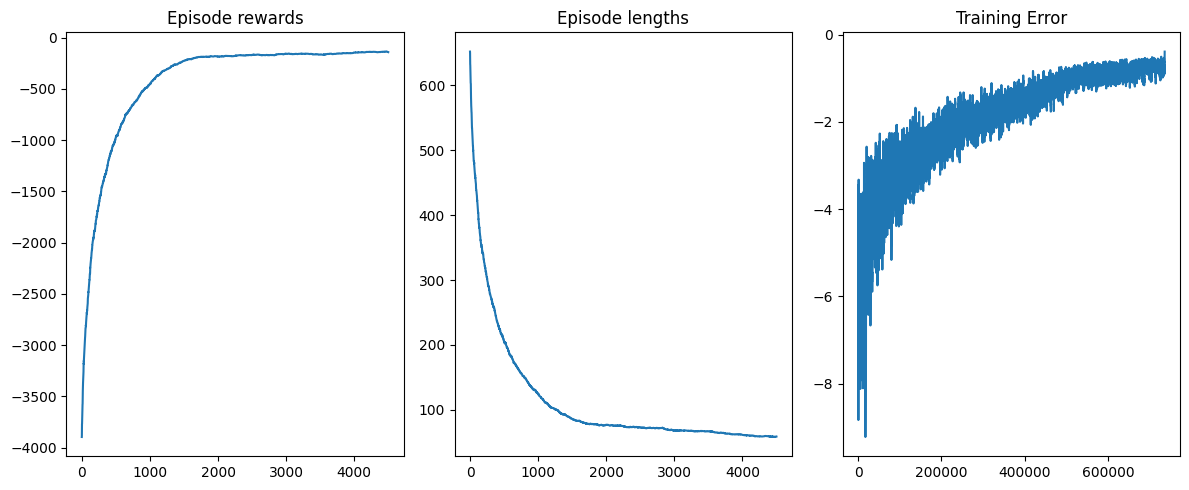

In [9]:
learn(learning_rate, n_episodes, start_epsilon, epsilon_decay, final_epsilon, name)

### Test 2

In [46]:
learning_rate = 0.02
n_episodes = 5_000
start_epsilon = 1
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.2
name = "test02"

100%|██████████| 5000/5000 [01:37<00:00, 51.20it/s]  


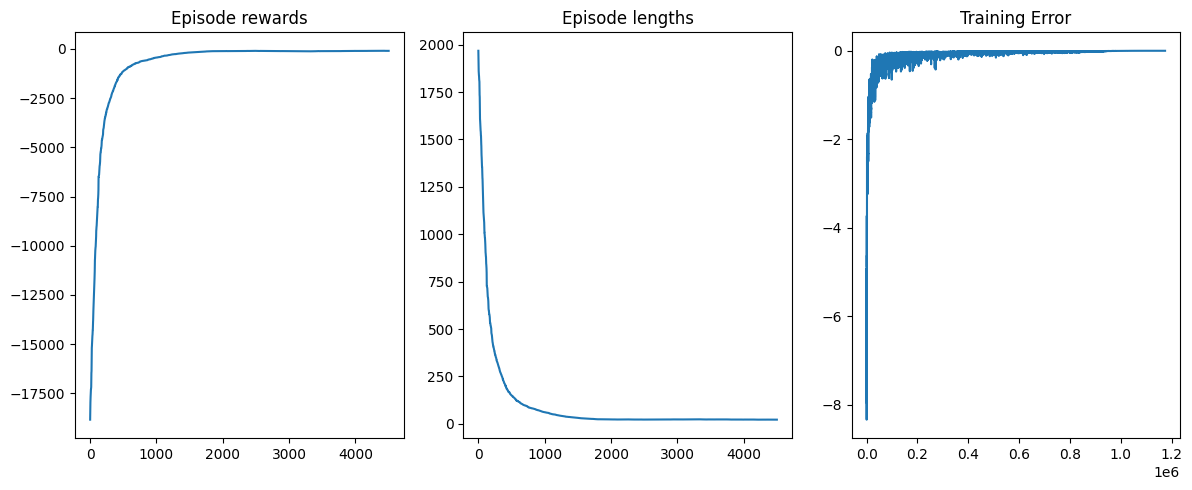

In [47]:
learn(learning_rate, n_episodes, start_epsilon, epsilon_decay, final_epsilon, name)

### Test 3

In [48]:
learning_rate = 0.01
n_episodes = 5_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)
final_epsilon = 0.1
name = "test03"

100%|██████████| 5000/5000 [00:20<00:00, 243.46it/s] 


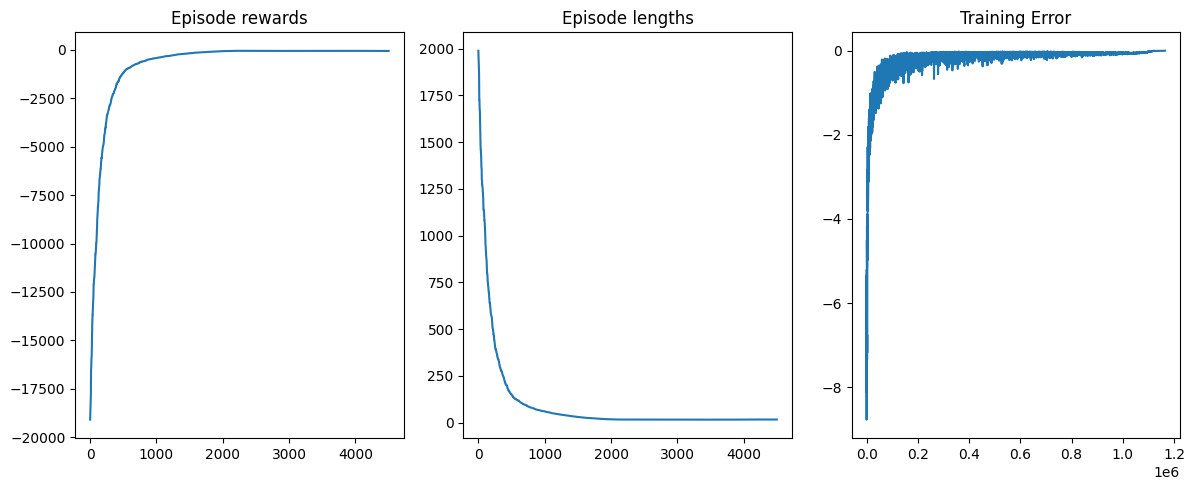

In [49]:
learn(learning_rate, n_episodes, start_epsilon, epsilon_decay, final_epsilon, name)

### Learning video creation

In [37]:
import os
from moviepy import VideoFileClip, concatenate_videoclips, vfx
import re

In [50]:
folder_path = "CliffWalking_test03/"

def extract_episode_number(filename):
    match = re.search(r'episode-(\d+)', filename)
    return int(match.group(1)) if match else -1

video_files = sorted([
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if f.endswith(".mp4")
], key=lambda x: extract_episode_number(os.path.basename(x)))

clips = []
for i, path in enumerate(video_files):
    clip = VideoFileClip(path).with_effects([vfx.MultiplySpeed(4)])
    clips.append(clip)

final_video = concatenate_videoclips(clips, method="compose")
final_video.write_videofile("cliffwalking_all_episodes.mp4", fps=30)

{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [720, 240], 'bitrate': 21, 'fps': 4.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.19.100 libx264'}}], 'input_number': 0}], 'duration': 921.25, 'bitrate': 21, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [720, 240], 'video_bitrate': 21, 'video_fps': 4.0, 'video_duration': 921.25, 'video_n_frames': 3685}
/Users/krzysztofczerenko/Projects_6_semester/python_env/lib/python3.10/site-packages/imageio_ffmpeg/binaries/ffmpeg-macos-aarch64-v7.1 -i CliffWalking_test03/training-episode-0.m

MoviePy - Done !
MoviePy - video ready cliffwalking_all_episodes.mp4
